In [56]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
from pyfaidx import Fasta
import upsetplot
from pandarallel import pandarallel

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [57]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [58]:
mt_df = pd.read_csv('../data/05_mastertable/poder_master_table_fixed_genics.tsv', sep='\t')
# mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

In [4]:
p_df = pd.read_csv(proc_cfg(config['lr']['poder_protein']['protein']['summary'], od), sep='\t')
p_df = p_df.merge(mt_df[['associated_gene_biotype',
                         'structural_category', 
                         'associated_transcript',
                         'isoform',
                         'associated_gene',
                         'length']],
                  how='left',
                  left_on='tid', 
                  right_on='isoform')
p_df.rename({'associated_gene':'gid',
             'protein_sequence':'seq'}, axis=1, inplace=True)
assert len(p_df.loc[p_df.isoform.isnull()]) == 0

## Limit to protein coding genes

In [5]:
# keep only things from annotated protein coding genes
p_df = p_df.loc[p_df.associated_gene_biotype=='Protein Coding']
n = len(p_df.index)
print(len(p_df.index))

# keep only things w/ full ORFs
p_df = p_df.loc[(p_df.protein_has_start_codon==True)&\
                (p_df.protein_has_stop_codon==True)]
print(len(p_df.index))

100666
100666


## Get reference AA sequences and merge on gid + sequence

In [19]:
# get annotated AA sequencesa
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs['tid'] =  ref_orfs.name.str.split('|', expand=True)[1]

ref_orfs = ref_orfs[['seq', 'gid']]
ref_orfs['annot_aa'] = True
ref_orfs.drop_duplicates(inplace=True)

In [7]:
# also add orf completeness as info!
gtf_file = proc_cfg(config['ref']['gtf'], od)
gtf_df = pr.read_gtf(gtf_file).df

start_codon_tids = gtf_df.loc[gtf_df.Feature=='start_codon', 'transcript_id'].unique().tolist()
stop_codon_tids = gtf_df.loc[gtf_df.Feature=='stop_codon', 'transcript_id'].unique().tolist()
gtf_df = gtf_df[['transcript_id']].drop_duplicates()

gtf_df['has_start_codon'] = gtf_df.transcript_id.isin(start_codon_tids)
gtf_df['has_stop_codon'] = gtf_df.transcript_id.isin(stop_codon_tids)

gtf_df = gtf_df.loc[gtf_df.transcript_id.notnull()]
gtf_df['has_complete_orf'] = (gtf_df.has_start_codon)&(gtf_df.has_stop_codon)

assert len(gtf_df.transcript_id.unique()) == len(gtf_df.index)

In [20]:
# just going to call novel aas as those that are not in the 
# pc translations gencode file
l1 = len(p_df.index)
p_df = p_df.merge(ref_orfs, how='left', on=['gid', 'seq'])
l2 = len(p_df.index)
assert l1 == l2
p_df['annot_aa'] = p_df['annot_aa'].fillna(False)

100666
100666


In [24]:
# merge in information of if there was a complete annotated orf to begin with
p_df = p_df.merge(gtf_df, 
                  how='left', 
                  left_on='associated_transcript',
                  right_on='transcript_id')

In [26]:
p_df[['isoform', 'annot_aa', 'structural_category', 'has_complete_orf']].groupby(['annot_aa', 'has_complete_orf', 'structural_category']).nunique()

isoform
annot_aa has_complete_orf structural_category         
False    False            FSM                    25834
         True             FSM                     3315
True     False            FSM                     1315
         True             FSM                    37704

So most FSMs w/o a matching full-length ORF don't have a matching AA

In [28]:
p_df[['isoform', 'annot_aa', 'structural_category']].groupby(['annot_aa', 'structural_category']).nunique()

isoform
annot_aa structural_category         
False    FSM                    29149
         NIC                    12330
         NNC                    13897
True     FSM                    39019
         NIC                     3176
         NNC                     3095

## Get our own protein sequence novelty categories
1. exact AA match
2. truncated AA match
3. novel, non-truncation AA seq

In [27]:
# 2. truncated AA match
def get_aa_seq_truncations(x, ref_orfs):
    # limit to just references from same gene
    temp = ref_orfs.loc[ref_orfs.gid == x.gid]
    for ind, entry in temp.iterrows():
        if x.seq in entry.seq:
            return True
    return False

# p_df['trunc_annot_aa'] = p_df.apply(lambda x: get_aa_seq_truncations(x, ref_orfs), axis=1)

In [34]:
# p_df.to_csv('temp.tsv', sep='\t')

In [30]:
# 2. elongated AA match
def get_aa_seq_elongations(x, ref_orfs):
    # limit to just references from same gene
    temp = ref_orfs.loc[ref_orfs.gid == x.gid]
    for ind, entry in temp.iterrows():
        if entry.seq in x.seq:
            return True
    return False

# p_df['elong_annot_aa'] = p_df.apply(lambda x: get_aa_seq_elongations(x, ref_orfs), axis=1)

In [31]:
# p_df.to_csv('temp.tsv', sep='\t')

In [63]:
# p_df.to_csv('250223_protein_characterization_mt.tsv', sep='\t')

## What % of novel transcripts, PC-gene transcripts have an ORF predicted?

In [26]:
def fmt_perc_print(n_num, n):
    return f'{(n_num/n)*100:.2f}% ({n_num}/{n})'

In [54]:
novel_pc_df = mt_df.loc[(mt_df.associated_gene_biotype=='Protein Coding')&(mt_df.structural_category!='FSM')]
n = len(novel_pc_df.index)
tids = novel_pc_df.isoform.tolist()

assert n == 33737 # number reported in the paper just double checking (2d)

n_num = len(p_df.loc[p_df.isoform.isin(tids)].isoform.unique())
s = fmt_perc_print(n_num, n)
print(f'{s} novel, protein-coding transcripts have a predicted full ORF')

96.33% (32498/33737) novel, protein-coding transcripts have a predicted full ORF


## What % of novel transcripts, PC-gene transcripts have a non-NMD ORF predicted?

In [60]:
novel_pc_df = mt_df.loc[(mt_df.associated_gene_biotype=='Protein Coding')&(mt_df.structural_category!='FSM')]
n = len(novel_pc_df.index)
tids = novel_pc_df.isoform.tolist()

assert n == 33737 # number reported in the paper just double checking (2d)

n_num = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)].isoform.unique())
s = fmt_perc_print(n_num, n)
print(f'{s} novel, protein-coding transcripts have a predicted full ORF w/o predicted NMD')

83.39% (28134/33737) novel, protein-coding transcripts have a predicted full ORF w/o predicted NMD


## What % of novel, PC-gene transcripts w/ non-NMD ORF encode for a novel AA seq (wrt the sequences from the same gene)?

In [61]:
novel_pc_df = mt_df.loc[(mt_df.associated_gene_biotype=='Protein Coding')&(mt_df.structural_category!='FSM')]
n = len(novel_pc_df.index)
tids = novel_pc_df.isoform.tolist()

assert n == 33737 # number reported in the paper just double checking (2d)

n = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)].isoform.unique())

n_num = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)&
                     (p_df.annot_aa==False)].isoform.unique())
s = fmt_perc_print(n_num, n)
print(f'{s} novel, protein-coding transcripts w/ pred. full ORF and w/o predicted NMD are predicted to have a novel AA seq')

80.58% (22671/28134) novel, protein-coding transcripts w/ pred. full ORF and w/o predicted NMD are predicted to have a novel AA seq


## What % of novel, PC-gene transcripts w/ non-NMD ORF encode for a novel AA seq (excluding truncations) (wrt the sequences from the same gene)?

In [64]:
novel_pc_df = mt_df.loc[(mt_df.associated_gene_biotype=='Protein Coding')&(mt_df.structural_category!='FSM')]
n = len(novel_pc_df.index)
tids = novel_pc_df.isoform.tolist()

assert n == 33737 # number reported in the paper just double checking (2d)

n = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)].isoform.unique())

n_num = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)&
                     (p_df.annot_aa==False)&
                     (p_df.trunc_annot_aa==False)].isoform.unique())
s = fmt_perc_print(n_num, n)
print(f'{s} novel, protein-coding transcripts w/ pred. full ORF and w/o predicted NMD are predicted to have a novel AA seq that is not a truncation of an annotated one')

61.11% (17194/28134) novel, protein-coding transcripts w/ pred. full ORF and w/o predicted NMD are predicted to have a novel AA seq that is not a truncation of an annotated one


In [65]:
# this is a good sanity check because I get the same number as in `explore_orfs_aas_2.ipynb`

#### And for this analysis, what is the number of unique AA seqs?

In [77]:
n_num = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)&
                     (p_df.annot_aa==False)&
                     (p_df.trunc_annot_aa==False)][['gid', 'seq']].drop_duplicates())
print(f'{n_num} novel, non-truncation, unique AA seq+gene pairs from novel transcripts'+\
      'from protein coding genes,'+\
      'not predicted to have nmd, not truncations.')

15553 novel, non-truncation, unique AA seq+gene pairs from novel transcriptsfrom protein coding genes,not predicted to have nmd, not truncations.


## What % of novel AA seqs represent extensions of known ones (wrt the sequences from the same gene)?

In [79]:
novel_pc_df = mt_df.loc[(mt_df.associated_gene_biotype=='Protein Coding')&(mt_df.structural_category!='FSM')]
n = len(novel_pc_df.index)
tids = novel_pc_df.isoform.tolist()

assert n == 33737 # number reported in the paper just double checking (2d)

n = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)&
                     (p_df.annot_aa==False)&
                     (p_df.trunc_annot_aa==False)][['gid', 'seq']].drop_duplicates())

n_num = len(p_df.loc[(p_df.isoform.isin(tids))&
                     (p_df.protein_is_nmd==False)&
                     (p_df.annot_aa==False)&
                     (p_df.trunc_annot_aa==False)&
                     (p_df.elong_annot_aa==True)][['gid', 'seq']].drop_duplicates())

s = fmt_perc_print(n_num, n)
print(f'{s} of uniq novel non-truncation, non-nmd AA seqs from novel transcripts from PC genes are elongations of existing ones from the same gene')

21.89% (3405/15553) of uniq novel non-truncation, non-nmd AA seqs from novel transcripts from PC genes are elongations of existing ones from the same gene


## For the rest of these novel things, what do the blastp identities look like ?

In [84]:
novel_pc_df = mt_df.loc[(mt_df.associated_gene_biotype=='Protein Coding')&(mt_df.structural_category!='FSM')]
n = len(novel_pc_df.index)
tids = novel_pc_df.isoform.tolist()

assert n == 33737 # number reported in the paper just double checking (2d)

temp = p_df.loc[(p_df.isoform.isin(tids))&
                 (p_df.protein_is_nmd==False)&
                 (p_df.annot_aa==False)&
                 (p_df.trunc_annot_aa==False)&
                 (p_df.elong_annot_aa==False)]

# get only uniq aa seqs / blast ids
temp = temp[['gid', 'seq', 'blastp_identity']].drop_duplicates()

In [87]:
assert len(temp[['gid', 'seq']].drop_duplicates()) == len(temp.index)

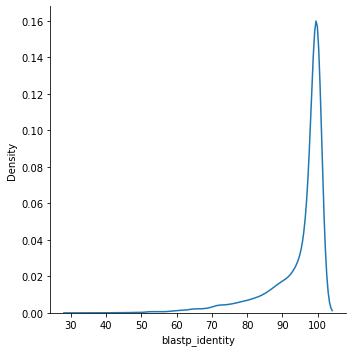

In [86]:
sns.displot(temp,
            kind='kde',
            x='blastp_identity')

In [ ]:
high_blastp_thresh = 90
temp['high_blastp'] = temp.blastp_identity>=high_blastp_thresh

In [90]:
temp[['seq', 'high_blastp']].groupby(['high_blastp']).count()

,seq
high_blastp,
False,3715
True,8433


## Ok now switching gears -- with the categorization of non-nmd ORFs only, what % of CDS FSMs that don't match actually had an incomplete orf in gencode?

In [94]:
# add status of fsm cdss

# get annotated AA sequencesa
fasta_file = proc_cfg(config['ref']['pc'], od)
fasta = Fasta(fasta_file)

# Extract each entry's name and sequence
ref_orfs = {
    "name": [entry.name for entry in fasta],
    "seq": [str(entry) for entry in fasta]
}

ref_orfs = pd.DataFrame(ref_orfs)
ref_orfs['gid'] =  ref_orfs.name.str.split('|', expand=True)[2]
ref_orfs['tid'] = ref_orfs.name.str.split('|', expand=True)[1]
ref_orfs.head()


,name,seq,gid,tid
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,MKKVTAEAISWNESTSETNNSMVTEFIFLGLSDSQELQTFLFMLFF...,ENSG00000186092.7,ENST00000641515.2
1,ENSP00000409316.1|ENST00000426406.4|ENSG000002...,MDGENHSVVSEFLFLGLTHSWEIQLLLLVFSSVLYVASITGNILIV...,ENSG00000284733.2,ENST00000426406.4
2,ENSP00000329982.2|ENST00000332831.5|ENSG000002...,MDGENHSVVSEFLFLGLTHSWEIQLLLLVFSSVLYVASITGNILIV...,ENSG00000284662.2,ENST00000332831.5
3,ENSP00000478421.2|ENST00000616016.5|ENSG000001...,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...,ENSG00000187634.13,ENST00000616016.5
4,ENSP00000480678.2|ENST00000618323.5|ENSG000001...,MPAVKKEFPGREDLALALATFHPTLAALPLPPLPGYLAPLPAAAAL...,ENSG00000187634.13,ENST00000618323.5


In [99]:
temp = p_df.loc[p_df.protein_is_nmd==False]

temp['aa_seq_novelty'] = 'Novel'
temp.loc[(temp.annot_aa==True), 'aa_seq_novelty'] = 'Known'
temp.loc[(temp.annot_aa==False)&\
         (temp.trunc_annot_aa==True), 'aa_seq_novelty'] = 'Truncation'

temp.loc[~(temp.isoform.isin(ref_orfs.tid.tolist()))&\
         (temp.structural_category=='FSM')]

temp.loc[~(temp.associated_transcript.isin(ref_orfs.tid.tolist()))&\
         (temp.structural_category=='FSM'),'structural_category'] = 'FSM w/o CDS'

In [100]:
temp2 = temp[['isoform', 'aa_seq_novelty', 'structural_category']].groupby(['aa_seq_novelty', 'structural_category']).nunique().rename({'isoform':'n_t'}, axis=1)
temp2 = temp2.reset_index()
temp2

,aa_seq_novelty,structural_category,n_t
0,Known,FSM,34094
1,Known,FSM w/o CDS,842
2,Known,NIC,2647
3,Known,NNC,2816
4,Novel,FSM,3039
5,Novel,FSM w/o CDS,11109
6,Novel,NIC,7325
7,Novel,NNC,9869
8,Truncation,FSM,3870
9,Truncation,FSM w/o CDS,5218


In [104]:
temp = temp.loc[(temp.structural_category=='FSM')&
                (temp.aa_seq_novelty=='Novel')]
n = len(temp)

n_num = len(temp.loc[temp.has_complete_orf==False])
s = fmt_perc_print(n_num, n)
print(f'{s} of FSM (with CDS) transcripts that we predict novel AA seq do not have a complete ORF annotated in GENCODE')

54.72% (1663/3039) of FSM (with CDS) transcripts that we predict novel AA seq do not have a complete ORF annotated in GENCODE


## Similarly, maybe some of these can also be explained by just being elongations

In [106]:
temp = temp.loc[(temp.structural_category=='FSM')&
                (temp.aa_seq_novelty=='Novel')]
n = len(temp)

n_num = len(temp.loc[temp.elong_annot_aa==True])
s = fmt_perc_print(n_num, n)
print(f'{s} of FSM (with CDS) transcripts that we predict novel AA seq are elongations of annot. seqs from the same gene')

23.96% (728/3039) of FSM (with CDS) transcripts that we predict novel AA seq are elongations of annot. seqs from the same gene


## Get a summary table for sankey plot

In [32]:
import pandas as pd
p_df = pd.read_csv('250223_protein_characterization_mt.tsv', sep='\t')

In [34]:
# just for novel transcripts
# AA categories are NMD, known, known truncation, 
# known elongation, novel
p_df.loc[p_df.has_complete_orf==False]

print(len(p_df.index))
df = p_df.loc[(p_df.structural_category!='FSM')&\
              (p_df.structural_category!="FSM w/o CDS")]
print(len(df.index))

,Unnamed: 0,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,...,isoform,gid,length,annot_aa,transcript_id,has_start_codon,has_stop_codon,has_complete_orf,trunc_annot_aa,elong_annot_aa
6,6,chr1,17626006,17697868,+,HAVANA,ORFanage,17627332,17691151,ENST00000167825.5,...,ENST00000167825.5,ENSG00000074964.17,3018,False,ENST00000167825.5,False,True,False,True,False
11,11,chr9,5784560,5825285,-,HAVANA,ORFanage,5787146,5825187,ENST00000214893.10,...,ENST00000214893.10,ENSG00000099219.15,4724,False,ENST00000214893.10,False,False,False,True,False
14,14,chrX,53584210,53686728,-,HAVANA,ORFanage,53584280,53654107,ENST00000218328.12,...,ENST00000218328.12,ENSG00000086758.17,5488,False,ENST00000218328.12,False,False,False,False,True
16,16,chr16,53235136,53327451,+,HAVANA,ORFanage,53238367,53324892,ENST00000219084.10,...,ENST00000219084.10,ENSG00000177200.18,8739,False,ENST00000219084.10,False,False,False,True,False
35,35,chr4,153555895,153636711,+,HAVANA,ORFanage,153556977,153636573,ENST00000240487.5,...,ENST00000240487.5,ENSG00000121210.16,4299,False,ENST00000240487.5,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100658,100658,chr2,181457369,181487876,+,Cerberus,ORFanage,181457654,181485997,transcript_99938,...,transcript_99938,ENSG00000115232.14,3322,False,ENST00000465522.5,False,False,False,False,False
100660,100660,chr2,181457427,181509805,+,Cerberus,CPAT,181485977,181494752,transcript_99940,...,transcript_99940,ENSG00000115232.14,2070,False,ENST00000233573.6,True,False,False,False,False
100663,100663,chr2,181493033,181495832,+,Cerberus,CPAT,181493324,181494752,transcript_99983,...,transcript_99983,ENSG00000115232.14,573,False,ENST00000473002.1,False,False,False,False,False
100664,100664,chr2,181498280,181511771,+,Cerberus,CPAT,181509661,181509793,transcript_99989,...,transcript_99989,ENSG00000115232.14,720,False,ENST00000490435.5,False,False,False,False,False


100666
32498


In [10]:
print(len(p_df.index))
df = p_df.loc[(p_df.structural_category!='FSM')&\
              (p_df.structural_category!="FSM w/o CDS")]
print(len(df.index))

# completely novel
df['aa_novelty_2'] = ''
df.loc[(df.annot_aa==False)&\
       (df.protein_is_nmd==False)&\
       (df.trunc_annot_aa==False)&\
       (df.elong_annot_aa==False), 'aa_novelty_2'] = 'Novel'

# known elongation
df.loc[(df.annot_aa==False)&\
       (df.protein_is_nmd==False)&\
       (df.trunc_annot_aa==False)&\
       (df.elong_annot_aa==True), 'aa_novelty_2'] = 'Known elongation'

# known truncation
df.loc[(df.annot_aa==False)&\
       (df.protein_is_nmd==False)&\
       (df.trunc_annot_aa==True), 'aa_novelty_2'] = 'Known truncation'

# known
df.loc[(df.annot_aa==True), 'aa_novelty_2'] = 'Known'

# NMD
df.loc[df.protein_is_nmd==True, 'aa_novelty_2'] = 'NMD'

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [11]:
temp = df[['structural_category', 'aa_novelty_2', 'isoform']].groupby(['structural_category', 'aa_novelty_2']).nunique()
temp

isoform
structural_category aa_novelty_2             
NIC                 Known                2647
                    Known elongation     2111
                    Known truncation     3044
                    NMD                  2490
                    Novel                5214
NNC                 Known                2816
                    Known elongation     1682
                    Known truncation     2433
                    NMD                  1874
                    Novel                8187

In [12]:
temp.to_csv('250224_protein_table_for_alluvial.tsv', sep='\t')

In [13]:
# df.loc[(df.annot_aa==True)&(df.protein_is_nmd==True)]

In [110]:
# df.loc[(df.trunc_annot_aa==True)&
#        (df.elong_annot_aa==True)]

,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,pid,...,gid,length,annot_aa,transcript_id,has_start_codon,has_stop_codon,has_complete_orf,trunc_annot_aa,elong_annot_aa,aa_seq_novelty
58,chr14,54842016,54902811,-,HAVANA,ORFanage,54844019,54902663,ENST00000254299.8,ENSP00000419045.2,...,ENSG00000131979.20,2901,True,ENST00000254299.8,False,False,False,True,True,Known
153,chr5,66158126,66180811,+,HAVANA,ORFanage,66159271,66178865,ENST00000284041.7,ENSP00000370305.3,...,ENSG00000153914.16,3751,True,ENST00000284041.7,False,False,False,True,True,Known
255,chr16,87707811,87750942,-,HAVANA,ORFanage,87707916,87730607,ENST00000316853.10,ENSP00000482433.1,...,ENSG00000104731.14,1287,True,ENST00000316853.10,False,False,False,True,True,Known
408,chr5,96728308,96772819,+,HAVANA,ORFanage,96730794,96771676,ENST00000348386.7,ENSP00000422677.2,...,ENSG00000310517.1,2272,False,ENST00000348386.7,False,False,False,True,True,Truncation
754,chr10,16593312,16817463,-,HAVANA,ORFanage,16593396,16782034,ENST00000377911.1,ENSP00000339521.5,...,ENSG00000148484.18,955,True,ENST00000377911.1,False,False,False,True,True,Known
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100613,chr1,226063475,226072002,+,Cerberus,ORFanage,226064351,226071476,transcript_9954,ENSP00000466020.1,...,ENSG00000163041.13,1263,True,NaN,NaN,NaN,NaN,True,True,Known
100627,chr2,178112409,178129656,+,Cerberus,ORFanage,178112546,178126173,transcript_99666,ENSP00000286070.5,...,ENSG00000155636.16,1868,True,NaN,NaN,NaN,NaN,True,True,Known
100633,chr2,178450464,178461380,+,Cerberus,ORFanage,178456079,178461271,transcript_99766,ENSP00000494225.1,...,ENSG00000204311.15,1098,True,NaN,NaN,NaN,NaN,True,True,Known
100634,chr2,178450492,178461287,+,Cerberus,ORFanage,178456079,178461271,transcript_99767,ENSP00000494225.1,...,ENSG00000204311.15,1081,True,NaN,NaN,NaN,NaN,True,True,Known


In [111]:
df.loc[df.trunc_annot_aa!=df.elong_annot_aa]

,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,pid,...,gid,length,annot_aa,transcript_id,has_start_codon,has_stop_codon,has_complete_orf,trunc_annot_aa,elong_annot_aa,aa_seq_novelty
11,chr9,5784560,5825285,-,HAVANA,ORFanage,5787146,5825187,ENST00000214893.10,ENSP00000340427.5,...,ENSG00000099219.15,4724,False,ENST00000214893.10,False,False,False,True,False,Truncation
14,chrX,53584210,53686728,-,HAVANA,ORFanage,53584280,53654107,ENST00000218328.12,ENSP00000262854.6,...,ENSG00000086758.17,5488,False,ENST00000218328.12,False,False,False,False,True,Novel
16,chr16,53235136,53327451,+,HAVANA,ORFanage,53238367,53324892,ENST00000219084.10,ENSP00000455307.1,...,ENSG00000177200.18,8739,False,ENST00000219084.10,False,False,False,True,False,Truncation
44,chr9,131258075,131264715,-,HAVANA,ORFanage,131260824,131261202,ENST00000247295.4,ENSP00000361343.3,...,ENSG00000126882.14,4560,False,ENST00000247295.4,False,False,False,True,False,Truncation
100,chr4,112605559,112636995,-,HAVANA,ORFanage,112607874,112633176,ENST00000264370.9,ENSP00000426938.1,...,ENSG00000138658.16,3583,False,ENST00000264370.9,False,False,False,False,True,Novel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100587,chr2,176269403,176338025,+,Cerberus,ORFanage,176269629,176337498,transcript_99427,ENSP00000398757.1,...,ENSG00000128654.14,1176,False,NaN,NaN,NaN,NaN,False,True,Novel
100588,chr2,176269403,176338034,+,Cerberus,ORFanage,176328337,176337661,transcript_99428,ENSP00000414176.1,...,ENSG00000128654.14,1315,False,NaN,NaN,NaN,NaN,True,False,Truncation
100615,chr2,177216721,177223336,+,Cerberus,ORFanage,177219110,177219296,transcript_99590,ENSP00000400688.2,...,ENSG00000170144.23,1828,False,NaN,NaN,NaN,NaN,True,False,Truncation
100635,chr2,178451310,178461394,+,Cerberus,ORFanage,178451757,178461271,transcript_99768,ENSP00000364271.4,...,ENSG00000204311.15,1617,False,NaN,NaN,NaN,NaN,False,True,Novel


## number of truly novel AA seqs from NIC / NNC

In [20]:
len(df.loc[df.aa_novelty_2 == 'Novel'][['seq', 'gid']].drop_duplicates())

12148

## BLAST vals. of truly novel AA seqs

In [21]:
temp = df.loc[df.aa_novelty_2 == 'Novel']

# get only uniq aa seqs / blast ids
temp = temp[['gid', 'seq', 'blastp_identity']].drop_duplicates()

high_blastp_thresh = 90
temp['high_blastp'] = temp.blastp_identity>=high_blastp_thresh
temp[['seq', 'high_blastp']].groupby(['high_blastp']).count()

,seq
high_blastp,
False,3715
True,8433


## Perc. NIC / NNC that encode for truly novel

In [30]:
n = len(df.loc[df.structural_category.isin(['NIC', 'NNC'])].isoform.unique())
n_num  = len(df.loc[(df.structural_category.isin(['NIC', 'NNC']))&
                (df.aa_novelty_2=='Novel')].isoform.unique())



In [31]:
s = fmt_perc_print(n_num, n)
print(f'{s} of NNC/NIC transcripts from PC genes are predicted to encode for a completely novel AA seq (not nmd, not elongation or truncation or known)')

41.24% (13401/32498) of NNC/NIC transcripts from PC genes are predicted to encode for a completely novel AA seq (not nmd, not elongation or truncation or known)


## Add some of this extra protein info to the master table

In [49]:
mt_df = pd.read_csv('../supp_tables/04_poder_mt.tsv', sep='\t')
p_df = pd.read_csv('250223_protein_characterization_mt.tsv', sep='\t')

In [50]:
print(len(p_df.index))
df = p_df.loc[(p_df.structural_category!='FSM')&\
              (p_df.structural_category!="FSM w/o CDS")]
print(len(df.index))

# completely novel
df['aa_novelty_2'] = ''
df.loc[(df.annot_aa==False)&\
       (df.protein_is_nmd==False)&\
       (df.trunc_annot_aa==False)&\
       (df.elong_annot_aa==False), 'aa_novelty_2'] = 'Novel'

# known elongation
df.loc[(df.annot_aa==False)&\
       (df.protein_is_nmd==False)&\
       (df.trunc_annot_aa==False)&\
       (df.elong_annot_aa==True), 'aa_novelty_2'] = 'Known elongation'

# known truncation
df.loc[(df.annot_aa==False)&\
       (df.protein_is_nmd==False)&\
       (df.trunc_annot_aa==True), 'aa_novelty_2'] = 'Known truncation'

# known
df.loc[(df.annot_aa==True), 'aa_novelty_2'] = 'Known'

# NMD
df.loc[df.protein_is_nmd==True, 'aa_novelty_2'] = 'NMD'

100666
32498


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [51]:
df.rename({'aa_novelty_2':'aa_novelty'}, axis=1, inplace=True)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [52]:
df = df[['isoform',
         'trunc_annot_aa', 
         'elong_annot_aa',
         'annot_aa', 
         'aa_novelty']]
df.head()

,isoform,trunc_annot_aa,elong_annot_aa,annot_aa,aa_novelty
7251,transcript_100122,False,False,False,Novel
7255,transcript_100131,True,False,False,Known truncation
7257,transcript_100134,False,False,False,Novel
7258,transcript_100135,True,False,False,Known truncation
7276,transcript_100180,True,False,False,Known truncation


In [54]:
mt_df = mt_df.merge(df, how='left', 
                    on='isoform')

In [55]:
mt_df.to_csv('../supp_tables/04_poder_mt.tsv', sep='\t')

## Get the number of novel transcripts going into this analysis in the first place

In [68]:
p_df = pd.read_csv('250223_protein_characterization_mt.tsv', sep='\t')

In [69]:
# just for novel transcripts
# AA categories are NMD, known, known truncation, 
# known elongation, novel
p_df.loc[p_df.has_complete_orf==False]

print(len(p_df.index))
df = p_df.loc[(p_df.structural_category!='FSM')&\
              (p_df.structural_category!="FSM w/o CDS")]
print(len(df.index))

100666
32498


In [71]:
df.loc[df.tid.str.startswith('ENS')]

,Unnamed: 0,Chromosome,Start,Stop,Strand,Source,CDS_Source,CDS_Start,CDS_Stop,tid,...,isoform,gid,length,annot_aa,transcript_id,has_start_codon,has_stop_codon,has_complete_orf,trunc_annot_aa,elong_annot_aa
